In [447]:
import numpy as np
import nltk
from pprint import pprint
from collections import Counter
import itertools as it
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

def triplewise(iterable):
    "s -> (s0,s1,s2), (s1,s2,s3), (s2, s3,s4), ..."
    a, b = it.tee(iterable)
    b, c = it.tee(b)
    next(b, None)
    next(c, None)
    next(c, None)
    return zip(a, b,c)




from functools import reduce, lru_cache

In [259]:
from sample_chapters import *

In [267]:
@lru_cache(maxsize=None)
def ne_preprocess(raw_text):
    sents = nltk.sent_tokenize(raw_text)
    tokenised_sents = [nltk.word_tokenize(sent) for sent in sents]
    tagged_sents = nltk.pos_tag_sents(tokenised_sents)
    ne_sents = nltk.ne_chunk_sents(tagged_sents, binary=True)
    return list(ne_sents)

In [268]:
def get_name(ne_tree):
    return " ".join([tagged_leaf[0] for tagged_leaf in ne_tree.leaves()])
    
def get_named_entities(sent):
    for subsent in sent.subtrees(lambda ss:ss.label()=='NE'):
        yield get_name(subsent)


In [324]:
def get_main_character_by_voting(raw_text, breakdown=False, vote_over=get_named_entities, weights=it.repeat(1)):
    ne_sents = ne_preprocess(raw_text)

    votes=Counter()
    for (name, weight) in zip(it.chain(*[vote_over(sent) for sent in ne_sents]), weights):
        votes[name]+= weight
        
    if breakdown:
        return votes
    else:
        if len(votes)>0:
            return votes.most_common(1)[0][0]
        else:
            return None


In [270]:
VERBS = frozenset({"MD","VB","VBD","VBG","VBN","VBP","VBZ"})
def patterned_name_entities(ne_sent):
    for e1,e2 in pairwise(ne_sent):
        if type(e1)!=nltk.tree.Tree or e1.label()!='NE':
            continue
        
        if type(e2)==tuple and e2[1] in VERBS:
            
            yield get_name(e1)

In [272]:
print(get_main_character_by_voting(sample_memoriesoflight_rand,vote_over=patterned_name_entities))
print(get_main_character_by_voting(sample_falloflight_renarr_1,vote_over=patterned_name_entities))
print(get_main_character_by_voting(sample_falloflight_Renarr_2,vote_over=patterned_name_entities))
print(get_main_character_by_voting(sample_falloflight_havaral_1,vote_over=patterned_name_entities))
print(get_main_character_by_voting(sample_falloflight_havaral_2,vote_over=patterned_name_entities))
print(get_main_character_by_voting(sample_falloflight_none,vote_over=patterned_name_entities))

Rand
Renarr
Renarr
Havaral
Havaral
Tug


In [273]:
import json
from collections import defaultdict

In [274]:
annotated_data = []

def load_append(fn):    
    with open(fn,"r") as fh:
        annotated_data.extend(json.load(fh))
        
load_append("test_data/asoiaf01-04.json")
load_append("test_data/aDwD.json")
load_append("test_data/Rick Riordan - [Heroes of Olympus 02] - The Son of Neptune (epub).json")
load_append("test_data/Rick Riordan - [Heroes of Olympus 05] - The Blood of Olympus (epub).json")
load_append("test_data/Leigh Bardugo - [Dregs 01] - Six of Crows.json")

#load_append("test_data/Jonathan Stroud - [Bartimaeus 01] - The Amulet of Samarkand.json")
#load_append("test_data/Jonathan Stroud - [Bartimaeus 02] - The Golem's Eye.json")
#load_append("test_data/Jonathan Stroud - [Bartimaeus 03] - Ptolemy's Gate.json")
#load_append("test_data/Jonathan Stroud - [Bartimaeus 04] - The Ring of Solomon.json")



In [275]:
unique_texts=set(datum['text'] for datum in annotated_data)
assert len(annotated_data)==len(unique_texts)

In [276]:
reference_characters = [datum['character'] for datum in annotated_data]

In [277]:
#reference_characters

In [322]:
output_characters = [get_main_character_by_voting(datum['text'],
                                                  vote_over=patterned_name_entities,
                                                  weights=map(lambda x:1+1.0/x**0.5,it.count(1))
                                                 ) for datum in annotated_data]


In [323]:
name2nicknames = defaultdict(lambda:tuple(),{
    "Daenerys": {"Dany",},
    "Eddard" : {"Ned"},
    "Samwell" :{"Sam"},
})

def correct(actual, ref):
    return actual==ref or actual in name2nicknames[ref]   

errors = [(index, actual, ref) for index, (actual, ref) in enumerate(zip(output_characters, reference_characters)) 
    if not (correct(actual,ref))]
len(errors)/len(reference_characters)

0.06277056277056277

In [325]:
from collections import namedtuple

In [341]:
ne_preprocess("Bill was sad. Bill hated Joe.")

[Tree('S', [Tree('NE', [('Bill', 'NNP')]), ('was', 'VBD'), ('sad', 'JJ'), ('.', '.')]),
 Tree('S', [Tree('NE', [('Bill', 'NNP')]), ('hated', 'VBD'), Tree('NE', [('Joe', 'NNP')]), ('.', '.')])]

In [523]:
def get_tag(item):
    if type(item)==nltk.tree.Tree:
        return item.label()
    elif type(item)==tuple:
        return item[1]
    else:
        assert(type(item) in [tuple, nltk.tree.Tree])

from nltk.data import load
tagset = list(load('help/tagsets/upenn_tagset.pickle').keys())
tagset.append('NE')
tagset.append('PAD')

#FeatureVec = namedtuple(rank, count_below_top, lead, lag, verbs_before, verbs_after)
#namedtuple("FeatureVec", field_names =  "rank, count_below_top, lead, lag, verbs_before, verbs_after".split(", "))
def FeatureVec():
    vec=dict()
    vec["occur_count"]=0
    vec["occur_percent"]=0.0
    vec["first_occur_position"]=0
    vec["first_occur_percent"]=0.0
    vec["last_occur_position"]=0
    vec["last_occur_percent"]=0.0
    vec["rank"]=0
    vec["rank_percent"]=0
    for tag in tagset:
        vec["before_POS_was_"+tag]=0
        vec["after_POS_was_"+tag]=0
        vec["before_POS_was_percent_"+tag]=0.0
        vec["after_POS_was_percent_"+tag]=0.0
    return vec

def get_feature_vectors(raw_text, best_n=10):
    
    ne_sents = ne_preprocess(raw_text)
    ne_words = [("PAD","PAD")] +list(it.chain(*ne_sents)) + [("PAD","PAD")]
    
    feature_vecs = defaultdict(FeatureVec)
    overall_counts = Counter()
    
    for ii, (before, cur, after) in enumerate(triplewise(ne_words)):
        if type(cur)==nltk.tree.Tree and cur.label()=='NE':
            name = get_name(cur)
            overall_counts[name]+=1
            vec = feature_vecs[name]
            vec["occur_count"]+=1 #should be equal to overall_counts
            vec["before_POS_was_"+get_tag(before)]+=1
            vec["after_POS_was_"+get_tag(after)]+=1
            
            vec["last_occur_position"] = ii
            if not("first_occur_position" in vec):
                vec["first_occur_position"] = ii
    
    ###Basic data collected
    number_named_entities = len(overall_counts)
    
    #Fill up to counts
    #while len(overall_counts)<best_n:
    #    name = "filler_"+str(len(overall_counts))
    #    feature_vecs[name]=FeatureVec()
    #    overall_counts[name]=0
        
    #Final Percent processing, and flattening
    vectors=[]
    names=[]
    vector_keys = list(FeatureVec().keys())
    for rank,(name, count) in enumerate(overall_counts.most_common(n=best_n),1):
        
        vec = feature_vecs[name]
        assert(count==vec["occur_count"])
        vec["occur_percent"] = 100*count/sum(overall_counts.values())
        
        vec["rank"] = rank
        vec["rank_percent"] = 100*rank/number_named_entities
        vec["first_occur_percent"] = 100*vec["first_occur_position"] / len(ne_words)
        vec["last_occur_percent"] = 100*vec["last_occur_position"] / len(ne_words)
        
        for tag in tagset:
            vec["before_POS_was_percent_"+tag]=100*vec["before_POS_was_"+tag]/count
            vec["after_POS_was_percent_"+tag]=100*vec["after_POS_was_"+tag]/count
        
        
        vectors.append(list(vec.values()))       
        assert len(vectors[-1])==len(vector_keys), "%i != %i" % (len(vectors[-1]), len(vector_keys) )#Make sure I have everything
        names.append(name)
    
    return names, vectors, vector_keys
    
        
        

In [524]:
def get_binary_choice_feature_vectors(raw_text, reference_name):
    names, vectors, vector_keys = get_feature_vectors(raw_text)
    name_options = [reference_name]+list(name2nicknames[reference_name])
    return np.asarray(vectors), [(name in name_options) for name in names]

In [525]:
Xs,Ys = zip(*[get_binary_choice_feature_vectors(datum['text'],datum['character']) for datum in annotated_data])
Xs = list(it.chain(*Xs))
Ys = np.asarray(list(it.chain(*Ys)))

In [526]:
import sklearn.tree

In [527]:
classifier = sklearn.tree.DecisionTreeClassifier(class_weight='balanced')
classifier.fit(Xs,Ys)
Yhats = classifier.predict(Xs)

In [528]:
import sklearn.metrics
sklearn.metrics.accuracy_score(Ys,Yhats)

1.0

In [529]:
for imp, name in zip(classifier.feature_importances_, FeatureVec().keys()):
    print(name, "\t", imp )

after_POS_was_VBZ 	 0.0
before_POS_was_RBS 	 0.0
before_POS_was_`` 	 0.0
before_POS_was_NNP 	 0.00181522093188
before_POS_was_'' 	 0.0
before_POS_was_percent_RBR 	 0.0
after_POS_was_VBG 	 0.0
before_POS_was_percent_WP 	 0.0
after_POS_was_NNS 	 0.0
after_POS_was_RB 	 0.0
after_POS_was_CC 	 0.000958757143917
after_POS_was_JJ 	 0.0
after_POS_was_percent_UH 	 0.0
after_POS_was_percent_( 	 0.0
before_POS_was_VBG 	 0.0
before_POS_was_percent_( 	 0.0
after_POS_was_percent_CD 	 0.0
before_POS_was_percent_VBG 	 0.0
before_POS_was_percent_NNS 	 0.0
after_POS_was_percent_RB 	 0.0
after_POS_was_percent_RBS 	 0.0
before_POS_was_WDT 	 0.0
before_POS_was_percent_. 	 0.0078582133746
after_POS_was_percent_-- 	 0.0
before_POS_was_WRB 	 0.0
before_POS_was_percent_VBP 	 0.0
before_POS_was_VBD 	 0.00352378824257
before_POS_was_percent_WDT 	 0.0
after_POS_was_TO 	 0.0
before_POS_was_percent_$ 	 0.0
before_POS_was_POS 	 0.0
before_POS_was_PRP 	 0.0
before_POS_was_percent_VBZ 	 0.0
before_POS_was_percent_POS 

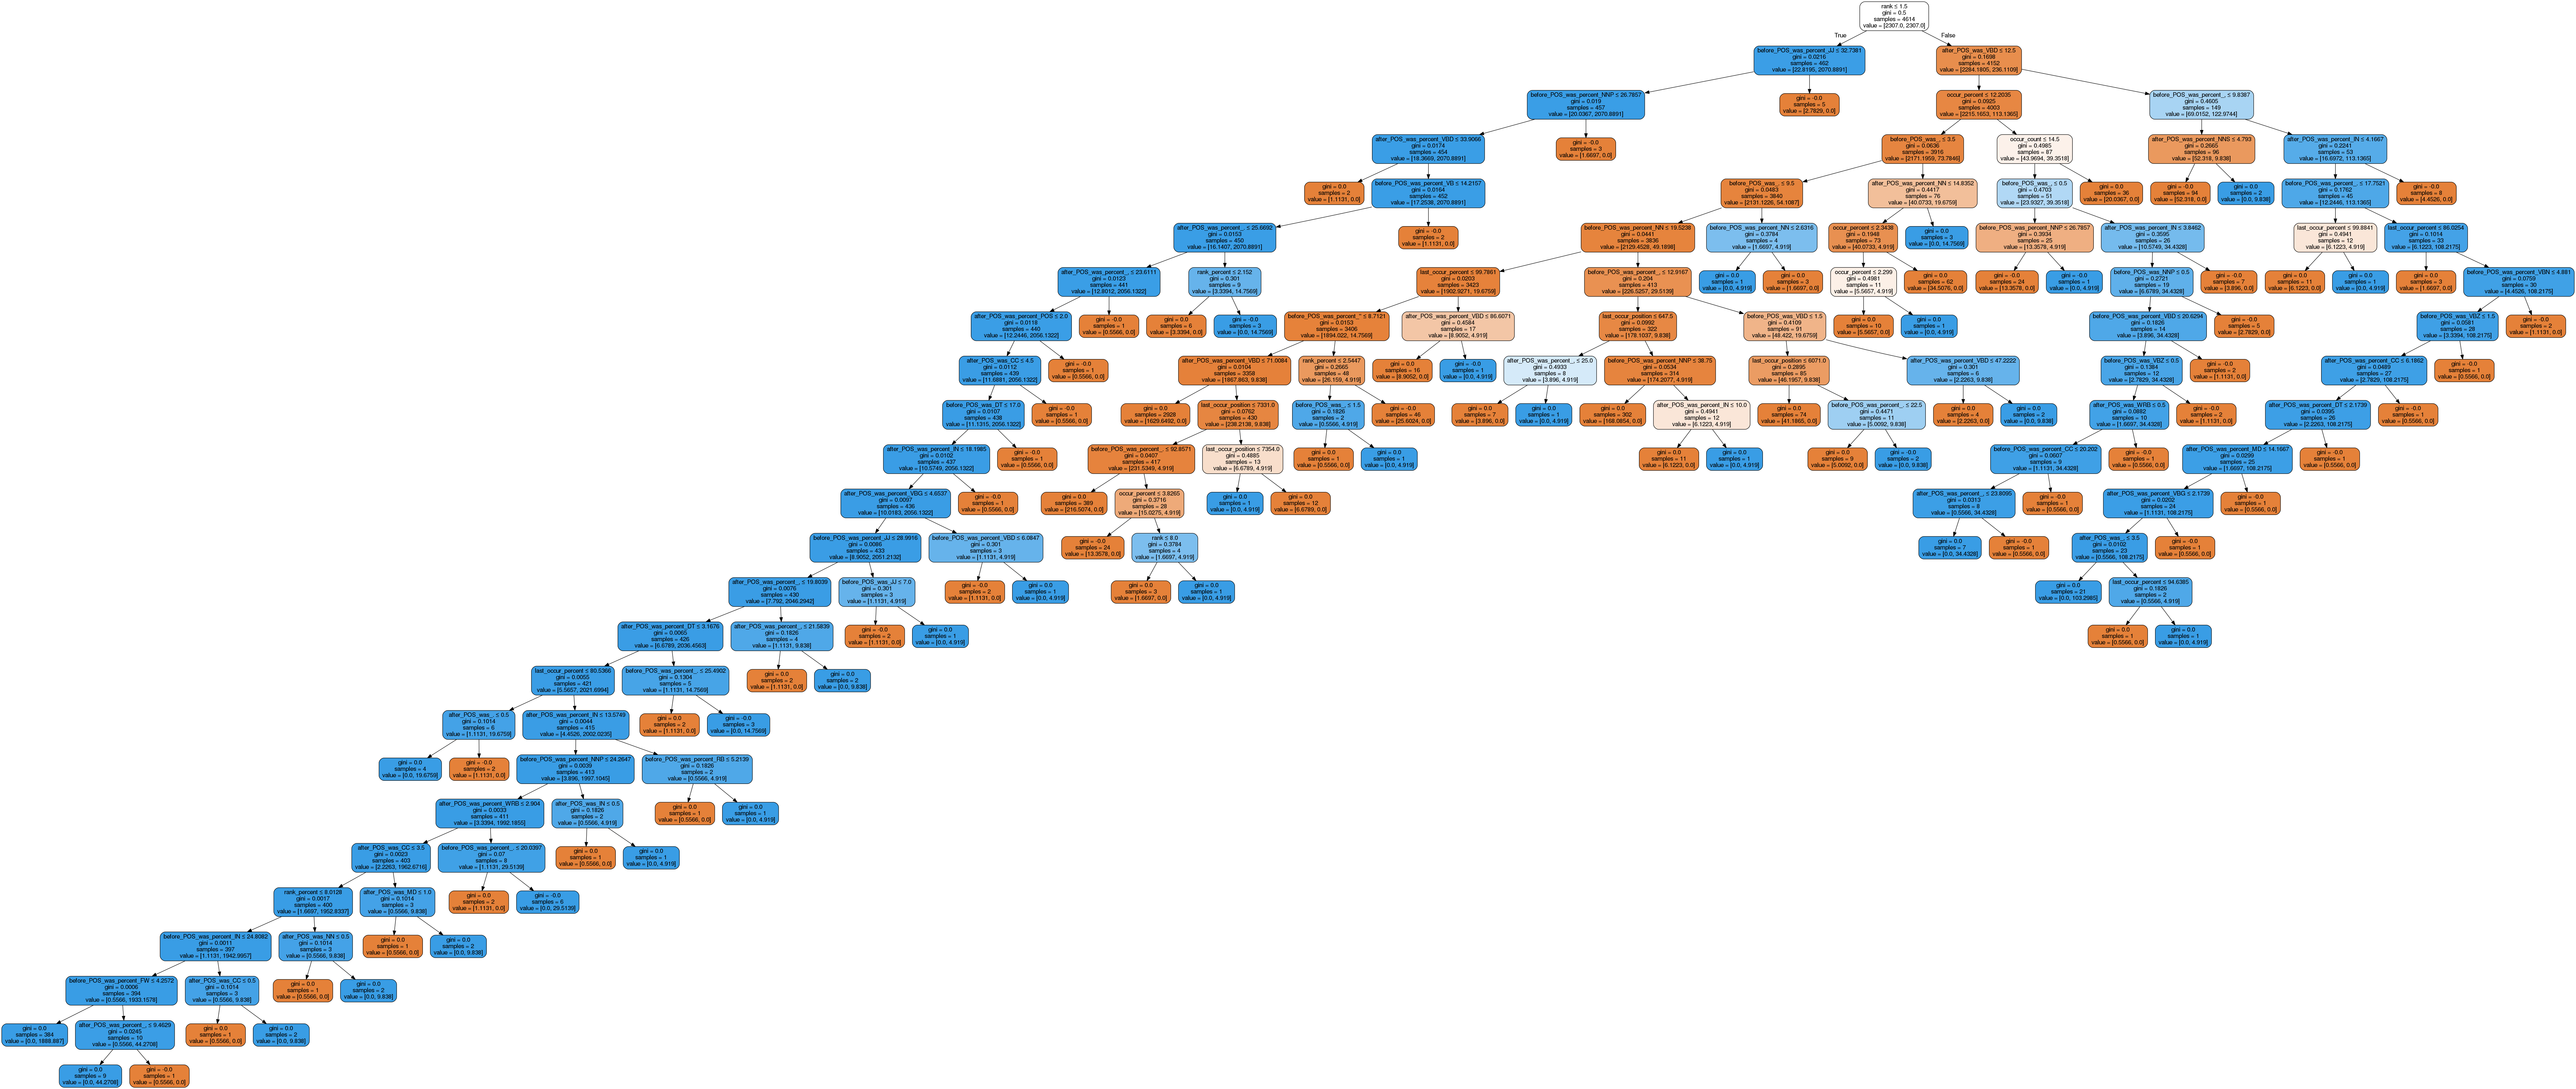

In [530]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus as pydot

dot_data = StringIO()  
sklearn.tree.export_graphviz(classifier, out_file=dot_data,  
                     feature_names=list(FeatureVec().keys()),  
                     #class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [327]:
#Basic Voting 0.08874458874458875
[(3, 'Robert', 'Eddard'),
 (11, 'Robert', 'Eddard'),
 (38, 'Robert', 'Eddard'),
 (41, 'Bronn', 'Tyrion'),
 (62, 'Robb', 'Catelyn'),
 (104, 'Brienne', 'Catelyn'),
 (125, 'Cersei', 'Tyrion'),
 (127, 'Asha', 'Theon'),
 (143, 'Gendry', 'Arya'),
 (151, 'Brienne', 'Jaime'),
 (154, 'Robb', 'Catelyn'),
 (160, 'Robb', 'Catelyn'),
 (171, 'Brienne', 'Jaime'),
 (174, 'Hound', 'Arya'),
 (177, 'Brienne', 'Jaime'),
 (179, 'Lord Beric', 'Arya'),
 (185, 'Robb', 'Catelyn'),
 (189, 'Robb', 'Catelyn'),
 (193, 'Cersei', 'Tyrion'),
 (207, 'Kingsguard', 'Jaime'),
 (260, 'Illyrio', 'Tyrion'),
 (314, 'Percy', 'Hazel'),
 (324, 'Frank', 'Hazel'),
 (331, 'Phineas', 'Percy'),
 (342, 'Frank', 'Percy'),
 (353, 'Percy', 'Frank'),
 (380, 'Hylla', 'Reyna'),
 (385, 'Percy', 'Jason'),
 (387, 'Reyna', 'Nico'),
 (390, 'Apollo', 'Leo'),
 (391, 'Apollo', 'Leo'),
 (401, 'Jason', 'Piper'),
 (417, 'Kaz', 'Inej'),
 (419, 'Kaz', 'Inej'),
 (433, 'Jordie', 'Kaz'),
 (443, 'Nina', 'Inej'),
 (456, 'Nina', 'Matthias'),
 (457, 'Nina', 'Inej'),
 (458, 'Kuwei', 'Nina'),
 (460, 'Van Eck', 'Kaz'),
 (461, 'Rollins', 'Pekka')]


#VERBs after Errors: 0.06493506493506493
[(3, 'Robert', 'Eddard'),
 (11, 'Robert', 'Eddard'),
 (38, 'Robert', 'Eddard'),
 (41, 'Bronn', 'Tyrion'),
 (151, 'Brienne', 'Jaime'),
 (160, 'Robb', 'Catelyn'),
 (171, 'Qyburn', 'Jaime'),
 (174, 'Hound', 'Arya'),
 (177, 'Bolton', 'Jaime'),
 (193, 'Lord Tywin', 'Tyrion'),
 (205, 'Hound', 'Arya'),
 (314, 'Percy', 'Hazel'),
 (324, 'Frank', 'Hazel'),
 (331, 'Phineas', 'Percy'),
 (333, 'Phineas', 'Percy'),
 (342, 'Frank', 'Percy'),
 (353, 'Percy', 'Frank'),
 (380, 'Hylla', 'Reyna'),
 (385, 'Percy', 'Jason'),
 (387, 'Bryce', 'Nico'),
 (390, 'Apollo', 'Leo'),
 (393, 'Asclepius', 'Leo'),
 (401, 'Hazel', 'Piper'),
 (407, 'Zeus', 'Jason'),
 (419, 'Kaz', 'Inej'),
 (433, 'Jordie', 'Kaz'),
 (456, 'Nina', 'Matthias'),
 (457, 'Nina', 'Inej'),
 (458, 'Kuwei', 'Nina'),
 (461, 'Rollins', 'Pekka')]
#
""


''

In [231]:
get_main_character_by_voting(annotated_data[1]['text'],True).most_common(10)

[('Catelyn', 11),
 ('Ned', 7),
 ('Eyrie', 4),
 ('Riverrun', 4),
 ('Starks', 3),
 ('Worship', 2),
 ('Jon', 2),
 ('Robert', 2),
 ('Bran', 2),
 ('Winterfell', 2)]

In [ ]:
text = list(ne_preprocess( annotated_data[1]['text']))

In [ ]:
print(type(text[0]))